# Naive (for now) attempts to build DL manually

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We need to start with a test. What should this network fit?

To go beyond linear regression, let's consider a 2D case (x,y), and a non-linear landscape (a blob?).

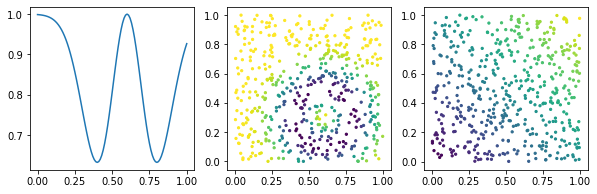

In [39]:
def target(xy, y=None, simple=False):
    if y is None:
        x = xy[:,0]
        y = xy[:,1]
    else:
        x = xy
    if simple:
        val = x+y
        val = val/max(val)
    else:
        d = np.sqrt((x-0.6)**2 + (y-0.3)**2)*5
        val = 1-np.exp(-d**2)*d**2
    return val

plt.figure(figsize=(10,3))
x = np.linspace(0,1,101)
plt.subplot(131)
plt.plot(x, target(x,0.3))

xy = np.random.uniform(size=(500,2))
z = target(xy, simple=False)
plt.subplot(132);
plt.scatter(xy[:,0], xy[:,1], s=5, c=z);

xy = np.random.uniform(size=(500,2))
z = target(xy, simple=True)
plt.subplot(133);
plt.scatter(xy[:,0], xy[:,1], s=5, c=z);

Input dim = 2 (for one data point), and it seems to be a row. First layer then = n by 2 (assuming colum-vectors for vectors). Intermediate layers (if any): n1 by n2 (usually n2<n1). Last layer: 1 by m, as the output is only dim 1.

In [51]:
a = np.array([[1,2,3],[4,5,6]])
x = np.random.randn(3)
print(a)
print(x)
np.matmul(a,x)

[[1 2 3]
 [4 5 6]]
[ 1.32114532 -2.95116802 -0.34004956]


array([ -5.60133939, -11.51155615])

In [124]:
class Layer():
    """Neural Network Layer"""
    def __init__(self,m,n): # Dimensions are given in the order of logical human transformation: m-vec to n-vec
        self.w = np.random.randn(n,m)
        self.b = np.random.randn(n)
        
    def __str__(self):
        return 'W:' + str(self.w) + ";\n B:" + str(self.b)
    
    def shape(self):
        return self.w.shape[::-1]
    
    def run(self,x):
        if len(x)!=self.w.shape[1]:
            error("Dimensions don't match")
        self.out = np.maximum(0 , np.matmul(self.w , x) + self.b)
        return self.out
        
        
# test
l = Layer(3,2)
print(l)
print(l.run([1,2,3]))

W:[[ 0.27249908 -0.1782515   0.12955303]
 [ 1.28656406 -0.65000023  0.92865296]];
 B:[ 1.77959484 -0.77052503]
[2.08425    2.00199745]


In [130]:
class Network():
    """Full neural network"""
    def __init__(self,depth,nstart,nend):
        if depth==1:
            self.layers = [Layer(nstart,nend)]
        else:
            hi = nstart*3
            self.layers = []
            self.layers.append(Layer(nstart,hi))
            seq = [int(round(i)) for i in np.linspace(hi,nend,depth)]
            for i in range(depth-1):
                self.layers.append(Layer(seq[i],seq[i+1]))
    
    def __str__(self):
        return ''.join(['Layer '+str(l.shape())+';\n' for l in self.layers])
    
    def run(self,x):
        y = x.copy()
        for l in self.layers:
            #print(y)
            y = l.run(y)
        return y
    
    def step(self,x,y):
        """Training step"""
        yhat = self.run(x)
        loss = np.linalg.norm(yhat-y)
        return loss
    
    def train(self,xmat,ymat):
        loss = []
        for i in range(len(ymat)):
            loss.append(self.step(xmat[i,:],ymat[i]))
        return loss
                
# test
mynet = Network(3,2,1)
print(mynet)
mynet.run([2,3])

Layer (2, 6);
Layer (6, 4);
Layer (4, 1);



array([0.])

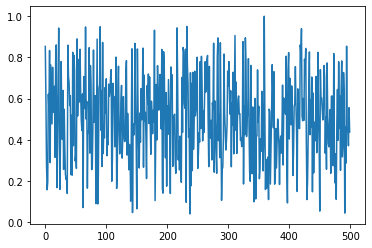

In [133]:
plt.plot(mynet.train(xy,z));

https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6